Trajectory Recommendation using HMM
=====

Build a HMM using POI feature and single step (i.e. POI pair) features, without using user-specific features.

# 1. Features

1. POI feature
  * POI popularity
  * POI category

1. Single step feature
  * Travel distance
  * Trajectory probability, computed from
    1. Transition probability from one POI category to another, 
       i.e. a POI category transition matrix
    1. Transition probability from a POI category to a specific POI of this category, 
       i.e. a transition vector for each POI category

# 2. Load Data

In [1]:
%matplotlib inline

import os
import math
import random
import pickle
import pandas as pd
import numpy as np
import numpy.matlib
from datetime import datetime
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [2]:
nfeatures = 8 # number of features
EPS = 1e-12 # smooth, deal with 0 probability
random.seed(123456789) # control random choice when splitting training/testing set

In [3]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [4]:
suffix = fvisit.split('-')[-1].split('.')[0]
fpoi = os.path.join(data_dir, 'poiHMM-' + suffix + '.csv')  
fseq = os.path.join(data_dir, 'seqHMM-' + suffix + '.csv')
ftrain = os.path.join(data_dir, 'trainsetHMM-' + suffix + '.pkl')
ftest  = os.path.join(data_dir, 'testsetHMM-' + suffix + '.pkl')
ffeatures_train = os.path.join(data_dir, 'featuresTrainHMM-' + suffix + '.pkl')
ffeatures_test  = os.path.join(data_dir, 'featuresTestHMM-' + suffix + '.pkl')

In [5]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
# merge data frames according to column 'photoID'
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID')
traj.head()

,photoID,userID,dateTaken,poiID,poiTheme,poiFreq,seqID,photoLon,photoLat
0,7941504100,10007579@N00,1346844688,30,Structure,1538,1,-79.380844,43.645641
1,4886005532,10012675@N05,1142731848,6,Cultural,986,2,-79.391525,43.654335
2,4886006468,10012675@N05,1142732248,6,Cultural,986,2,-79.391525,43.654335
3,4885404441,10012675@N05,1142732373,6,Cultural,986,2,-79.391525,43.654335
4,4886008334,10012675@N05,1142732445,6,Cultural,986,2,-79.391525,43.654335


In [22]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


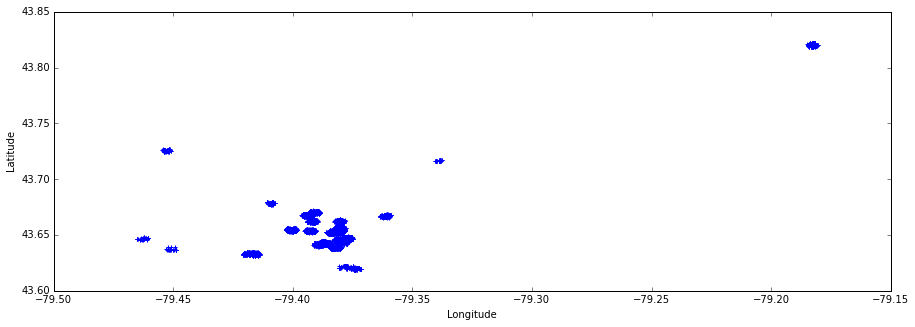

In [23]:
plt.figure(figsize=[15, 5])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(traj['photoLon'], traj['photoLat'], marker='+')

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [24]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [25]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [32]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
#poi_all.to_csv(fpoi, index=True)

Construct Travelling Sequences

In [41]:
seq_raw = traj[['seqID', 'poiID', 'dateTaken']].copy().groupby(['seqID', 'poiID']).agg([np.min, np.max, np.size])
seq_raw.columns = seq_raw.columns.droplevel()
seq_raw.reset_index(inplace=True)
seq_raw.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_raw['poiDuration(sec)'] = seq_raw['departureTime'] - seq_raw['arrivalTime']
seq_raw.head()

,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
0,1,30,1346844688,1346844688,1,0
1,2,6,1142731848,1142732445,4,597
2,3,6,1142916492,1142916492,1,0
3,4,13,1319327174,1319332848,9,5674
4,5,24,1196128621,1196128878,3,257


In [49]:
seq_len = seq_raw[['seqID', 'poiID']].copy().groupby('seqID').agg(np.size)
seq_len.reset_index(inplace=True)
seq_len.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_len.head()

,seqID,seqLen
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [87]:
seq_stats = seq_raw[['seqID', '#photo', 'poiDuration(sec)']].copy().groupby('seqID').agg(np.sum)
seq_stats.reset_index(inplace=True)
#seq_stats.rename(columns={'poiDuration(sec)':'totalPoiDuration(sec)'}, inplace=True)
seq_stats = pd.merge(seq_len, seq_stats, on='seqID')
seq_stats['poiDuration(sec)'] /= 60
seq_stats.rename(columns={'poiDuration(sec)':'totalPoiDuration(min)'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
seq_stats.head()

,seqLen,#photo,totalPoiDuration(min)
seqID,,,
1,1,1,0.000000
2,1,4,9.950000
3,1,1,0.000000
4,1,9,94.566667
5,1,3,4.283333


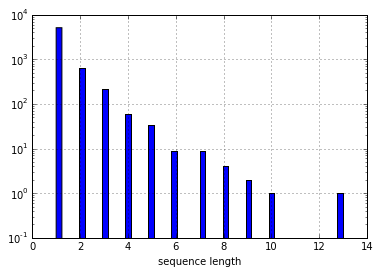

In [88]:
ax = seq_stats['seqLen'].hist(bins=50)
ax.set_xlabel('sequence length')
ax.set_ylim([0.1, 1e4])
ax.set_yscale('log')

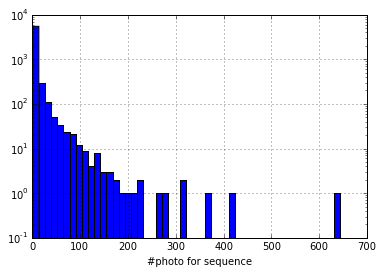

In [89]:
ax = seq_stats['#photo'].hist(bins=50)
ax.set_xlabel('#photo for sequence')
ax.set_ylim([0.1, 1e4])
ax.set_yscale('log')

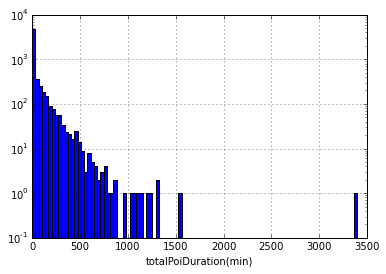

In [90]:
ax = seq_stats['totalPoiDuration(min)'].hist(bins=100)
ax.set_xlabel('totalPoiDuration(min)')
ax.set_ylim([0.1, 1e4])
ax.set_yscale('log')
#ax.set_xscale('log')

Sequences with length {3, 4, 5}

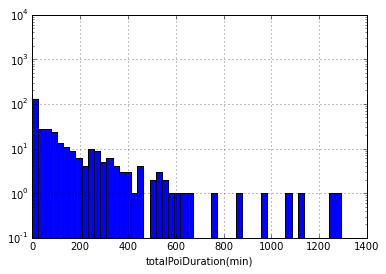

In [91]:
seq_stats = seq_stats[seq_stats['seqLen'].isin({3, 4, 5})]
ax = seq_stats['totalPoiDuration(min)'].hist(bins=50)
ax.set_xlabel('totalPoiDuration(min)')
ax.set_ylim([0.1, 1e4])
ax.set_yscale('log')

Do some filtering? (e.g. totalPoiDuration = 0 or too large, seqLen = 1 etc), 8 hours split vs. 6 hours split?

In [92]:
min_duration = 10  # 10 minutes
max_duration = 960 # 16 hours

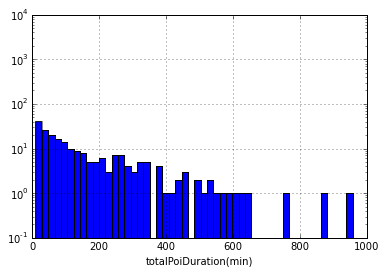

In [93]:
seq_stats = seq_stats[seq_stats['totalPoiDuration(min)'] > min_duration]
seq_stats = seq_stats[seq_stats['totalPoiDuration(min)'] < max_duration]
ax = seq_stats['totalPoiDuration(min)'].hist(bins=50)
ax.set_xlabel('totalPoiDuration(min)')
ax.set_ylim([0.1, 1e4])
ax.set_yscale('log')

Sequences with the same (start, end), some (start, end) are more popular than others.

what do we need? (start POI category, end POI category) vs. (start POI, end POI)

In [104]:
seq_dict = dict()
for seqid in seq_stats.index:
    assert(seq_stats.loc[seqid, 'seqLen'] >= 2)
    seqi = seq_raw[seq_raw['seqID'] == seqid].copy()
    seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
    pois = seqi['poiID'].tolist()
    p0 = pois[0]
    pN = pois[-1]
    if (p0, pN, len(pois)) not in seq_dict:
        seq_dict[(p0, pN, len(pois))] = []
    seq_dict[(p0, pN, len(pois))].append(pois)

max: 5 sequences with (start, end, seqLen) (23, 21, 3)
min: 1 sequences with (start, end, seqLen) (3, 22, 3)


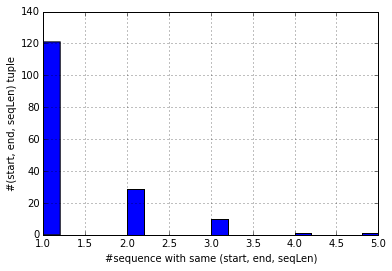

In [105]:
tuples = sorted(seq_dict.keys())
group_size = np.array([len(seq_dict[x]) for x in tuples])
maxidx = group_size.argmax()
minidx = group_size.argmin()
print('max: %d sequences with (start, end, seqLen) %s' % (group_size[maxidx], str(tuples[maxidx])))
print('min: %d sequences with (start, end, seqLen) %s' % (group_size[minidx], str(tuples[minidx])))
ax = pd.Series(group_size).hist(bins=20)
ax.set_xlabel('#sequence with same (start, end, seqLen)')
ax.set_ylabel('#(start, end, seqLen) tuples')

Split sequences into training set and testing set. which kind of split? hold one sequence in each type of (start, end)?

# 2. Compute Transition Probabilities

## 2.1 Basic Definitions

- $\text{Pr}(\text{POI}_i \to \text{POI}_j)$: 
   the transition probability from $\text{POI}_i$ to $\text{POI }_j$
- $\text{Pr}(\text{Cat}_i \to \text{Cat}_j)$:
   the transition probability from a POI of category $\text{Cat}_i$ to a POI of category $\text{Cat}_j$
- $\text{Pr}(\text{Pop}_i \to \text{Pop}_j)$:
   the transition probability from a POI of Popularity class $\text{Pop}_i$ to a POI of Popularity class $\text{Pop}_j$
- $\text{Pr}(\text{Dist}_i \to \text{Dist}_j)$:
   the transition probability from a POI-POI pair with distance (between the two) class $\text{Dist}_i$ to a POI-POI pair with distance (between the two) class $\text{Dist}_j$

By design, $\text{Pr}(\text{POI}_i \to \text{POI}_j)$ should be bigger 
if any of $\text{Pr}(\text{Cat}_i \to \text{Cat}_j)$, $\text{Pr}(\text{Pop}_i \to \text{Pop}_j)$ and
$\text{Pr}(\text{Dist}_i \to \text{Dist}_j)$ becomes bigger (if other factors stay the same).

So how to combine these probabilities?  
Both addition and multiplication seems to be able to serve this purpose, what is the difference?

### The Addition Case

For the addtion case, 

\begin{equation}
\text{Pr}(\text{POI}_i \to \text{POI}_j) = \frac{
\text{Pr}(\text{Cat}_{\text{POI}_i} \to \text{Cat}_{\text{POI}_j}) + 
\text{Pr}(\text{Pop}_{\text{POI}_i} \to \text{Pop}_{\text{POI}_j}) + 
\text{Pr}(\text{Dist}_{\text{POI}_{i-1} \to \text{POI}_i} \to \text{Dist}_{\text{POI}_{i} \to \text{POI}_j})
}
{Z_i}
\end{equation}

where $\text{POI}_{i-1}$ is the direct predecessor of $\text{POI}_i$ in a trajectory and $Z_i$ is a normalizing constant.

### The Multiplication Case

For the addtion case, 

\begin{equation}
\text{Pr}(\text{POI}_i \to \text{POI}_j) = \frac{
\text{Pr}(\text{Cat}_{\text{POI}_i} \to \text{Cat}_{\text{POI}_j}) \times
\text{Pr}(\text{Pop}_{\text{POI}_i} \to \text{Pop}_{\text{POI}_j}) \times
\text{Pr}(\text{Dist}_{\text{POI}_{i-1} \to \text{POI}_i} \to \text{Dist}_{\text{POI}_{i} \to \text{POI}_j})
}
{Z_i}
\end{equation}

similarly, $\text{POI}_{i-1}$ is the direct predecessor of $\text{POI}_i$ in a trajectory and $Z_i$ is again a normalizing constant.

### The Difference between Addition and Multiplication

It is important to note the fact that, by design, $\text{Pr}(\text{POI}_i \to \text{POI}_j)$ should be very small
if any of $\text{Pr}(\text{Cat}_i \to \text{Cat}_j)$, $\text{Pr}(\text{Pop}_i \to \text{Pop}_j)$ and
$\text{Pr}(\text{Dist}_i \to \text{Dist}_j)$ is very small, in the extreme case, if any of the three probabilities is $0$, then $\text{Pr}(\text{POI}_i \to \text{POI}_j)$ should be $0$
because the event "*Transition from POI$_i$ to POI$_j$*" is impossible.

From the equation of the addition case, it is clear that the addition rule **contradicts** the above fact while the multiplication rule is **consistent** with it.

Intuitively, the addition rule could make an unlikely event become much more likely, especially, 
make an impossible event become possible.

## 2.1 Transition Probabilities between POI Categories

In [1]:
def calc_poi_cat_transmat(seqid_set, poi_all, seq_all):
    poi_cats = poi_all['poiTheme'].unique().tolist()
    poi_cats.sort()
    poi_cat_transmat = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                                    index=poi_cats, columns=poi_cats)
    for seqid in train_set:
        seqi = seq_all[seq_all['seqID'] == seqid].copy()
        seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
        for j in range(len(seqi.index)-1):
            idx1 = seqi.index[j]
            idx2 = seqi.index[j+1]
            poi1 = seqi.loc[idx1, 'poiID']
            poi2 = seqi.loc[idx2, 'poiID']
            cat1 = poi_all.loc[poi1, 'poiTheme']
            cat2 = poi_all.loc[poi2, 'poiTheme']
            poi_cat_transmat.loc[cat1, cat2] += 1
    return poi_cat_transmat

In [ ]:
def normalise_transmat(transmat):
    assert(isinstance(transmat, pd.DataFrame))
    for row in transmat.index:
        nonzeroidx = np.nonzero(transmat.loc[row])[0].tolist()
        minv = np.min(transmat.ix[row, nonzeroidx])
        EPS = 0.2 * minv  # row-specific smooth factor
        zeroidx = list(set(range(len(transmat.columns))) - set(nonzeroidx))
        transmat.ix[row, zeroidx] = EPS
        rowsum = np.sum(transmat.loc[row])
        assert(rowsum > 0)
        transmat.loc[row] /= rowsum
    return transmat        

## 2.2 Transition Probabilities between POI Popularity Classes

### Discretize POI Popularity

### Compute Transition Probabilities

## 2.3 Transition Probabilities between POI Pair Distance Classes

### Discretize POI Pair Distance

### Compute Transition Probabilities

## 2.4 Transition Probabilities between POIs